# Project 3: Classification - Reddit Posts

In this part of the project, we will performed exploratory data analysis, feature engineering, modelling and evaluation.
We will create 4 models for our classification problem, select the one which best fit answer the business problem and perform an evaluation and justification on why the model is sellected 

### Contents:
- [Import Libraries and Load Data](#Import-Libraries-and-Load-Data)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Feature Engineering](#Feature-Engineering)
- [Selecting Original, Lemma or Stemmed Text](#Selecting-Original,-Lemma-or-Stemmed-Text)
- [Model Prepping](#Model-Prepping)
- [Modelling](#Modelling)
- [Evaluating Selected Model](#Evaluating-Selected-Model)
- [Conclusion](#Conclusion)

# Import Libraries and Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [2]:
combined_df = pd.read_csv('datasets/cleansed.csv')

# Exploratory Data Analysis

## Ratio of Posts and Baseline Accuracy

For the purpose of plotting a graph which is explainable, we will create a dataframe grouped by our subreddit class and rename our classes to a more readable name. We will then plot a bar graph to show the percentage count of the posts we have for each subreddit. This will also show us the baseline accuracy

In [3]:
eda_df = combined_df.groupby('subreddit').count()
eda_df.rename(index = {0 : 'learnprogram', 1: 'learnpython'}, inplace = True)

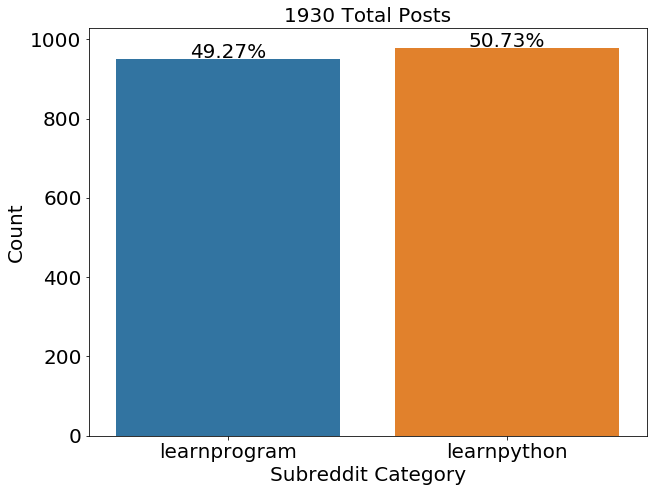

In [4]:
fig = plt.figure(figsize=(10, 7.5))
total = sum(eda_df.selftext)
ax = sns.barplot(x = eda_df.index, y = eda_df.selftext)
ax.set_title('{} Total Posts'.format(total), fontsize = 20)
ax.set_xlabel('Subreddit Category', fontsize = 20)
ax.set_ylabel('Count', fontsize = 20)
ax.tick_params(labelsize=20)

for p in ax.patches:
    ax.annotate('{}%'.format(round(p.get_height()/total * 100, 2) ), (p.get_x() + p.get_width() / 2, p.get_height() + 15), 
                ha = 'center', va = 'center',size = 20)

We have a total post count of 1930, 49.27% of them from learn programming and 50.73% from learn python. we have a healthy ratio of posts for each subreddit

In this instance, the baseline accuracy for a classification problem is the normalised value count of the higher class. From this graph we can also see that the baseline accuracy is 50.73%.

## Wordcloud

Drawing out a wordcloud allows us to immediately see if there are any common frequent words appearing at both subreddits. 

We first define a function called show_wordcloud which takes in 2 parameters, the corpus and the title of the wordcloud. We then ran the function on the corpus of subreddit learn python and also on subreddit learn programming 

In [5]:
def show_wordcloud(data, title):
    wordcloud = WordCloud(
        background_color='white',
        max_words=500,
        max_font_size=70,
        scale=3).generate(str(data))

    fig = plt.figure(1, figsize=(12, 10))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

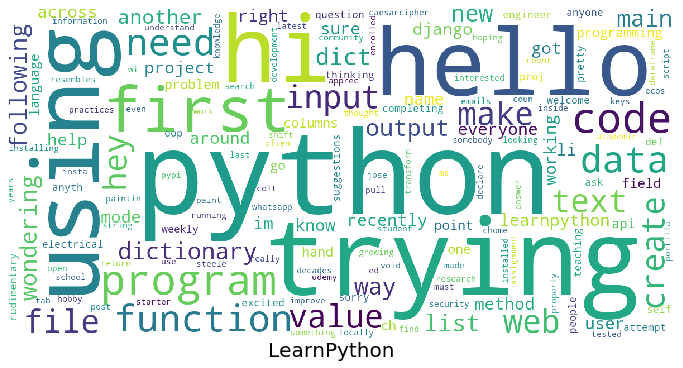

In [6]:
show_wordcloud(combined_df['selftext'][combined_df['subreddit'] == 1], 'LearnPython')

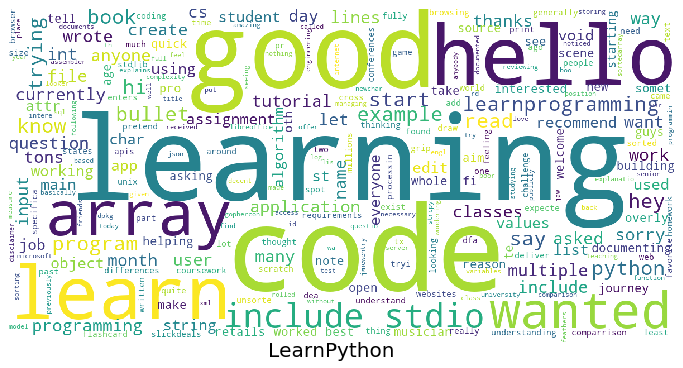

In [7]:
show_wordcloud(combined_df['selftext'][combined_df['subreddit'] == 0], 'LearnPython')

We can see that there are some common words like hello and code which appears frequently in both subreddits. As the topic selected is close, or can even be said that learn python can be considered a subset of learn programming. We can expect to see many common words which appear frequently in both subreddits.

## Top Words

Count vectorizer provides us with the count of words appearing in the corpus. We will use count vectorizer to help us identify the top 20 words for the entire corpus and plot a graph for visualisation. 

To tackle the problem of having too many common words amongst both subreddits, we will also utilize count vectorizer to help us identify the top common words. How we go about creating our customized stop words and the rationale behind the creationwill be explained in the section when we are creating it.

When performing count vectorizer for both purpose we would need to be mindful so as not to have too many customized stopwords which will cause us to have too little features left for modelling purpose, resulting in an underfit. 

To address the above problem, hyperparameters min_df and max_features were tuned. Min_df sets the minimum number of documents the word must appear in to be considered, and max_features sets the maximum number of words count vectorizer will select from our entire corpus 

We will first call out the column of interest for easier manipulation and set them as X and y.

In [8]:
X = combined_df['selftext']
y = combined_df['subreddit']

In [9]:
# only words appearing in minimum 20 documents and select a maximum of 2000 features

cv = CountVectorizer(min_df = 20, max_features = 2000)
common_cv = cv.fit_transform(X)
common_cv = pd.DataFrame(common_cv.todense(), 
                        columns=cv.get_feature_names())

In [10]:
# Create a data frame of the most common words 

n_words = 20
words = list(common_cv.sum().sort_values(ascending=False)[:n_words].index)
common_cv['subreddit'] = y.values
cv_train_small = common_cv.groupby('subreddit').sum()[words]

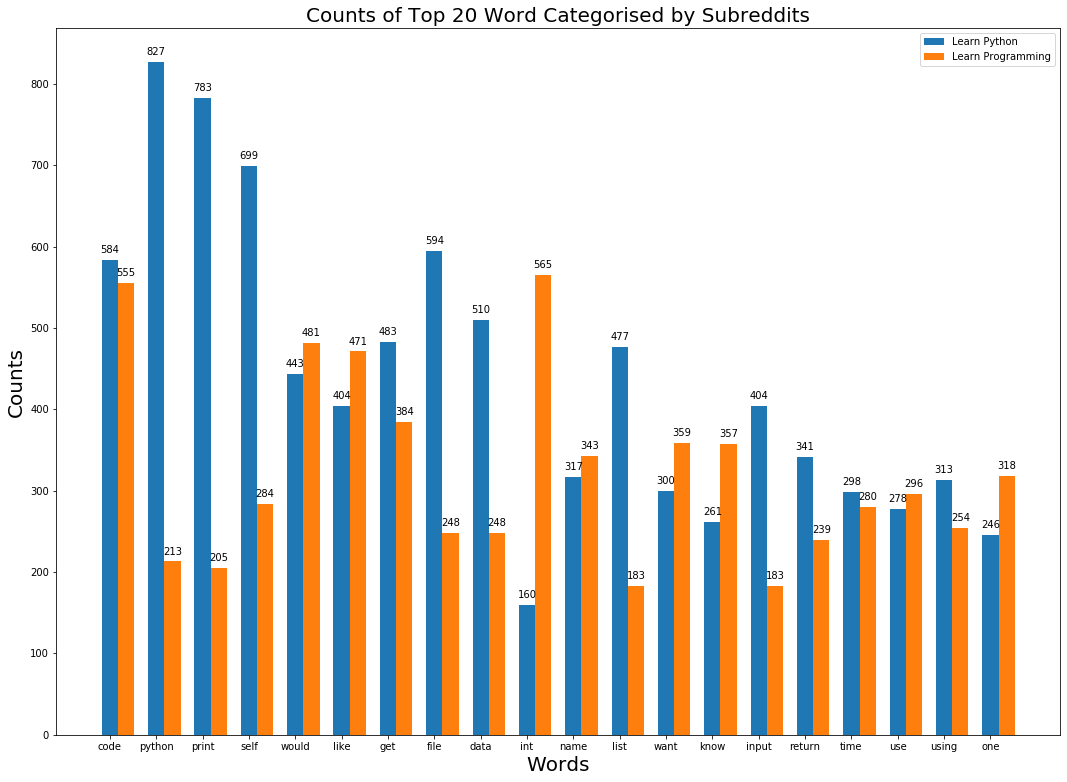

In [11]:
words_python = words
words_count_python = cv_train_small.loc[1]
words_program = words
words_count_program = cv_train_small.loc[0]
width = 0.35       
ind = np.arange(n_words)

fig, ax = plt.subplots(figsize=(18, 13))
rects1 = ax.bar(ind, words_count_python, width)
rects2 = ax.bar(ind+width, words_count_program, width)

# add some text for labels, title and axes ticks
ax.set_ylabel('Counts', fontsize = 20)
ax.set_xlabel('Words', fontsize = 20)
ax.set_title('Counts of Top 20 Word Categorised by Subreddits', fontsize = 20)
ax.set_xticks(ind)
ax.set_xticklabels(words)

ax.legend((rects1[0], rects2[0]), ('Learn Python', 'Learn Programming'))

for p in ax.patches:
    ax.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points', size = 10)

plt.show()

The graph above shows the top 20 common words based on appearance, and broken down by each subreddit. From the above we can see that the word 'code' is the top word and appeared a total of 1139 times, 584 in learn python, 555 in learn programming. 'Code' will be one of the word which we wish to include in our customized stopwords due to the small difference in appearance at both subreddits

Python is the top second word in the corpus appearing a total of 1040 times, 827 in learn python and 213 in learn programming. 
We can see that the word Python is a frequent word appearing more in to learn python. Another reason for python to appear so many times in programming is because python is a programming language and contributors of learn programming may also discuss python related topics. Python will not be a word to be included in our customized stop words as the frequency it appeared in learn python is significantly more than in learn programming.

# Feature Engineering

## Customized Stopwords

To create a list of our own stop words, we shall take the absolute value of the count of a word appearing in learn program minus the count of the word appearing in learn python. If the difference is less than 30, we shall include them in our customized stop words.

By having a difference of less than 30 appearance for both subreddit threads, we can infer that the word is a common word for both subreddit threads appearing almost equal number of times. Having mutually exclusive word is important for this problem as we are trying to classify the content of the post to the subreddit thread.

In [12]:
common_cv = common_cv.groupby('subreddit').sum()
common_words = []

for words in common_cv:
    if (abs(common_cv[words].loc[0] - common_cv[words].loc[1]) < 30):
        common_words.append(words)

In [13]:
len(common_words)

646

## Lemmatizer

We then performed lemmatizing on selftext and add them into another column, we will then perform a simple model on the different text to determine which text should we use.

Lemmatization reduces the words to the root word of the language keeping the word's context. For example, better and best will be reduced to the word good.

In [14]:
def lemmatize(selftext):
    lemmatizer = WordNetLemmatizer()
    tokenizer = RegexpTokenizer(r'\w+')
    return [lemmatizer.lemmatize(word) for word in tokenizer.tokenize(selftext)]

combined_df['lemma_text'] = combined_df.selftext.apply(lemmatize)
combined_df['lemma_text']= combined_df['lemma_text'].str.join(' ')

## Stemming

Similar to lematizing, we performed stemming and add the stemmed text into a new column, we will then run some tests to determine which of the 3 text should we use for our models.

Stemming a word is removing the suffixes or prefixes. This may cause the word to lose its context. for example care may be stemmed to become car.

For this classification problem, the context of the word is of no signifance as we are comparing words belonging to which subreddit and try to classify them. As such we can be safe to stem the words for our models.

In [15]:
def stemming(selftext):
    p_stemmer = PorterStemmer()
    tokenizer = RegexpTokenizer(r'\w+')
    return [p_stemmer.stem(word) for word in tokenizer.tokenize(selftext)]

combined_df['stem_text'] = combined_df.selftext.apply(stemming)
combined_df['stem_text']= combined_df['stem_text'].str.join(' ')

## Function

We will create 2 functions which will aid in selecting the optimum hyerparameters, fit and test our models.

pipeline_gridsearch will create a pipeline and perform a gridsearch on hyperparameters which we will define. Then perform a fit and test on our train data to provide us a score

fit_and_test will fit, test and perform predictions on our train and test data based on the optimal hyperparameters which our pipeline_gridsearch function had determined.

In [16]:
# Function for gridsearch

def pipeline_gridsearch(pipe, pipe_params, X_train, y_train):
    gs = GridSearchCV(pipe, param_grid=pipe_params, cv=5, n_jobs = -1)
    gs.fit(X_train, y_train)
    print(gs.best_score_) # best_score_ is gridsearch's function
    print(gs.best_params_)# best_params_ is gridsearch's function
    

In [17]:
# Function for fit, test and predict after getting optimum parameters

def fit_and_test(best_feature, best_model, X_train, X_test, y_train, y_test):
    X_train_featured = best_feature.fit_transform(X_train)
    X_test_featured = best_feature.transform(X_test)
    best_model.fit(X_train_featured, y_train)
    train_score = cross_val_score(best_model, X_train_featured, y_train, cv=10)
    #train_score = best_model.score(X_train_featured, y_train)
    test_score = best_model.score(X_test_featured, y_test)
    selected_features = best_feature.get_feature_names()
    
    coef = best_model.coef_
    predict = best_model.predict(X_test_featured)
    report = classification_report(y_test, best_model.predict(X_test_featured))
    con_matrix = confusion_matrix(y_test, predict)
    tn, fp, fn, tp = confusion_matrix(y_test, predict).ravel()
    probabilities = best_model.predict_proba(X_test_featured)
    
    
    print('{} features were selected'.format(len(selected_features)))
    print('Cross Validated Mean Train Score is: {}'.format(train_score.mean()))
    print('Test Score is: {}'.format(test_score))
    
   
    return (coef, predict, con_matrix, report, tn, fp, fn, tp, probabilities)   

# Selecting Original, Lemma or Stemmed Text

We will use count vectorizer with logistic regression followed by tfidf vectorizer with logistic regression to run a test on each of the 3 text to see which has the higher score. The one with the highest score will be the text used during the modeling prepping and modelling stage.

In [19]:
best_cvec = CountVectorizer(stop_words = common_words)
best_logreg = LogisticRegression(solver = 'lbfgs')

In [20]:
columns = ['selftext', 'stem_text', 'lemma_text']

for i in columns:
    X = combined_df[i]
    y = combined_df['subreddit']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify = y,
                                                    test_size = 0.25,
                                                    random_state = 42)
    
    print(i)
    fit_and_test(best_cvec, best_logreg, X_train, X_test, y_train, y_test)
    print('')

selftext
9558 features were selected
Cross Validated Mean Train Score is: 0.7802377578334121
Test Score is: 0.7432712215320911

stem_text
7065 features were selected
Cross Validated Mean Train Score is: 0.7484267569411641
Test Score is: 0.782608695652174

lemma_text
8649 features were selected
Cross Validated Mean Train Score is: 0.7691790662887735
Test Score is: 0.772256728778468



In [21]:
best_tvec = TfidfVectorizer(stop_words = common_words)
best_logreg = LogisticRegression(solver = 'lbfgs')

In [22]:
columns = ['selftext', 'stem_text', 'lemma_text']

for i in columns:
    X = combined_df[i]
    y = combined_df['subreddit']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify = y,
                                                    test_size = 0.25,
                                                    random_state = 42)
    
    print(i)
    fit_and_test(best_tvec, best_logreg, X_train, X_test, y_train, y_test)
    print('')

selftext
9558 features were selected
Cross Validated Mean Train Score is: 0.8051949168110009
Test Score is: 0.7867494824016563

stem_text
7065 features were selected
Cross Validated Mean Train Score is: 0.7905831758778145
Test Score is: 0.782608695652174

lemma_text
8649 features were selected
Cross Validated Mean Train Score is: 0.7996392956489792
Test Score is: 0.7846790890269151



From the above two tests, it is determined that lemma text achieves the best result amongst the three text. We shall use lemma text.

# Model Prepping

We will call out our lemma text and also our target, subreddit and split them into train and test datasets. The size for our training dataset will be 75% and the remaining 25% will be our testing dataset.  

In [18]:
X = combined_df['lemma_text']
y = combined_df['subreddit']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify = y,
                                                    test_size = 0.25,
                                                    random_state = 42)

# Modelling

We will begin our modelling to determine which model best fit our needs. Models that we will run are
- Count Vectorizer with Naive Bayesian's MultinomialNB
- Tfidf Vectorizer with Naive Bayesian's MultinomialNB
- Count Vectorizer with Logistics Regression
- Tfidf Vectorizer with Logistics Regression

The reason why Multinomial is selected instead of Bournalli and Gaussian of Naive Bayesian's model is because our features are all integer counts. Bernoulli will be better when we have 0/1 counts in all of our features(dummies) and Gaussian is better when our features are Normally distributed.

## Model 1 - Count Vectorizer with Naive Bayesian's Multinomial NB

We first call our function to run a pipeline and grid search to determine the optimum hyperparameter from those which we had selected ones

In [20]:
pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words = common_words)),
    ('nb', MultinomialNB())])


In [21]:
pipe_params = {
    'cvec__max_features': [None, 5000], # find out how many max features is better
    'cvec__min_df': [1, 3], # find out how many min documents the word is required to appear for it to be counted
    'cvec__max_df': [.09, 1.0], # find out what is the best perimeter to ignore words whether the words appear in 90% or 95% of documents
    'cvec__ngram_range': [(1,1), (1,2)], # find out what is the best ngram to use
    
    'nb__alpha': [1.0, 3.0],
    'nb__fit_prior' : [True, False]
}

In [27]:
best_params = pipeline_gridsearch(pipe, pipe_params, X_train, y_train)

0.7719419488597098
{'cvec__max_df': 1.0, 'cvec__max_features': None, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 2), 'nb__alpha': 1.0, 'nb__fit_prior': True}


After getting the optimum hyperameters from our gridsearch, we will fit and test our data with the hyperameters and look at the scores 

In [52]:
best_cvec = CountVectorizer(max_df = 1.0, max_features = None, min_df = 1, ngram_range = (1, 2), stop_words = common_words)
best_nb = MultinomialNB(alpha = 1.0, fit_prior = True)

In [53]:
m1_coef, m1_predict, m1_con_matrix, m1_report, m1_tn, m1_fp, m1_fn, m1_tp, m1_probabilities = fit_and_test(best_cvec, best_nb, X_train, X_test, y_train, y_test)

56489 features were selected
Cross Validated Mean Train Score is: 0.7712720437726344
Test Score is: 0.7805383022774327


A total of 56489 features was selected, our train and test score is quite close, there is no signs of overfitting for this model. Since there is no overfitting, we shall take a look at the confusion matrix and classification report.

In [54]:
# pred programming = 0 (Negative)
# pred python = 1 (Positive)

cm1_df = pd.DataFrame(m1_con_matrix, columns=['pred learn programming', 'pred learn python'], index=['actual learn programming', 'actual learn python'])
cm1_df

,pred learn programming,pred learn python
actual learn programming,192,46
actual learn python,60,185


In [55]:
print(m1_report)

              precision    recall  f1-score   support

           0       0.76      0.81      0.78       238
           1       0.80      0.76      0.78       245

    accuracy                           0.78       483
   macro avg       0.78      0.78      0.78       483
weighted avg       0.78      0.78      0.78       483



From the confusion matrix and classification report, we can see that we have 46 false positive compared to 60 false negative. This model's precision is 80% while its recall is 76%. 

## Model 2 - Tfidf Vectorizer with Naive Bayesian's Multinomial NB

Similar to model 1 we will perform a grid search first, then use the optimum parameter to fit and test our data

In [30]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer(stop_words = common_words)),
    ('nb', MultinomialNB())])

In [31]:
pipe_params = {
    'tvec__max_features': [None, 5000], # find out how many max features is better
    'tvec__min_df': [1, 2], # find out how many min documents the word is required to appear for it to be counted
    'tvec__max_df': [0.9, 1.0], # find out what is the best perimeter to ignore words whether the words appear in 90% or 95% of documents
    'tvec__ngram_range': [(1,1), (1,2)], # find out what is the best ngram to use
    
    'nb__alpha': [1.0, 3.0],
    'nb__fit_prior' : [True, False]
}

In [32]:
best_params = pipeline_gridsearch(pipe, pipe_params, X_train, y_train)

0.7878369039391845
{'nb__alpha': 3.0, 'nb__fit_prior': False, 'tvec__max_df': 0.9, 'tvec__max_features': 5000, 'tvec__min_df': 1, 'tvec__ngram_range': (1, 2)}


In [33]:
best_tvec = TfidfVectorizer(max_df = 0.9, max_features = 5000, min_df = 1, ngram_range = (1, 2), stop_words = common_words)
best_nb = MultinomialNB(alpha = 3.0, fit_prior = False)

In [34]:
coef, predict, con_matrix, report, tn, fp, fn, tp, probabilities = fit_and_test(best_tvec, best_nb, X_train, X_test, y_train, y_test)

5000 features were selected
Cross Validated Mean Train Score is: 0.781683855560804
Test Score is: 0.7681159420289855


A total of 5000 features was selected, although the mean train score is higher compared to model 1, our train and test scores are quite far apart, this model is overfitted. As this model is overfitted, we will not look deeper into its confusion matrix and classification report.

## Model 3 - Tfidf Vectorizer with Logistic Regression

The same iteration was performed again, this time with Tfidf Vectorizer with Logistic Regression

In [35]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer(stop_words = common_words)),
    ('lr', LogisticRegression(solver = 'liblinear'))])

In [36]:
pipe_params = {
    'tvec__max_features': [None, 5000], # find out how many max features is better
    'tvec__min_df': [1, 2], # find out how many min documents the word is required to appear for it to be counted
    'tvec__max_df': [0.9, 1.0], # find out what is the best perimeter to ignore words whether the words appear in 90% or 95% of documents
    'tvec__ngram_range': [(1,1), (1,2)], # find out what is the best ngram to use
        
    'lr__C': [1.0, 0.5],
    'lr__class_weight' : [None, 'balanced'],
    'lr__penalty' : ['l1', 'l2']
}

In [37]:
best_params = pipeline_gridsearch(pipe, pipe_params, X_train, y_train)

0.8071872840359364
{'lr__C': 1.0, 'lr__class_weight': None, 'lr__penalty': 'l2', 'tvec__max_df': 0.9, 'tvec__max_features': None, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 2)}


In [38]:
best_tvec = TfidfVectorizer(max_df = 0.9, max_features = None, min_df = 2, ngram_range = (1, 2), stop_words = common_words)
best_logreg = LogisticRegression(C = 1.0, class_weight = None, penalty = 'l2', solver = 'liblinear')

In [39]:
coef, predict, con_matrix, report, tn, fp, fn, tp, probabilities = fit_and_test(best_tvec, best_logreg, X_train, X_test, y_train, y_test)

8562 features were selected
Cross Validated Mean Train Score is: 0.8030972812680417
Test Score is: 0.782608695652174


A total 8562 features were selected. We can see that the train and test score is higher compared to model 1 and 2, however the difference between this score's mean train score and test score is also higher, this model is overfitted. As such we will not look deeper into this model's confusion and classification report.

The first model is the best amongst the three so far 

## Model 4 - Count Vectorizer With Logistic Regression

We will perform the same with Count Vectorizer with Logistic Regression

In [40]:
pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words = common_words)),
    ('lr', LogisticRegression(solver = 'liblinear'))])

In [41]:
pipe_params = {
    'cvec__max_features': [None, 5000], # find out how many max features is better
    'cvec__min_df': [1, 2], # find out how many min documents the word is required to appear for it to be counted
    'cvec__max_df': [0.9, 1.0], # find out what is the best perimeter to ignore words whether the words appear in 90% or 95% of documents
    'cvec__ngram_range': [(1, 1), (1, 2)], # find out what is the best ngram to use
            
    'lr__C': [1.0, 0.9],
    'lr__class_weight' : [None, 'balanced'],
    'lr__penalty' : ['l1', 'l2']
}

In [42]:
pipeline_gridsearch(pipe, pipe_params, X_train, y_train)

0.7823082239115411
{'cvec__max_df': 0.9, 'cvec__max_features': None, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 2), 'lr__C': 1.0, 'lr__class_weight': None, 'lr__penalty': 'l2'}


In [30]:
best_cvec = CountVectorizer(max_df = 0.9, max_features = None, min_df = 1, ngram_range = (1, 2), stop_words = common_words)
best_logreg = LogisticRegression(C = 1.0, class_weight = None, penalty = 'l2', solver = 'lbfgs')

In [31]:
m4_coef, m4_predict, m4_con_matrix, m4_report, m4_tn, m4_fp, m4_fn, m4_tp, m4_probabilities = fit_and_test(best_cvec, best_logreg, X_train, X_test, y_train, y_test)

56489 features were selected
Cross Validated Mean Train Score is: 0.7851084474885845
Test Score is: 0.7743271221532091


A total 56489 features were selected. We can see that this model has a better score compared to the first model and do not display signs of overfitting. We shall look at this model's classification report and confusion matrix

In [36]:
cm4_df = pd.DataFrame(m4_con_matrix, columns=['pred learn programming', 'pred learn python'], index=['actual learn programming', 'actual learn python'])
cm4_df

,pred learn programming,pred learn python
actual learn programming,183,55
actual learn python,54,191


In [37]:
print(m4_report)

              precision    recall  f1-score   support

           0       0.77      0.77      0.77       238
           1       0.78      0.78      0.78       245

    accuracy                           0.77       483
   macro avg       0.77      0.77      0.77       483
weighted avg       0.77      0.77      0.77       483



From the confusion matrix and classification report, we can see that we have 55 false positive compared to 54 false negative. This model's precision is 78% while its recall is 77%.

Recall the confusion matrix and classification report from the first model which have 46 false positive compared to 60 false negative. This model's precision is 80% while its recall is 76%.

For our use case, we are looking for a model with lesser false positive and higher precision as our evaluation metric. As such the first model is a best model amongst the 4. We will select the first model for further evaluation and explain the rationale of the selection.

# Evaluating Selected Model

For our use case, we are looking to classify a post and move them to the correct subreddit. A post from learn python appearing in learn programming subreddit is reasonable as python is a programming language.

We would not want to move a post which is suppose to be in learn programming into learn python subreddit. However, if we move learn python post to learn programming subreddit due to misclassification, the moved post will not seem to be out of place. From this, we can see that the cost of false positive is higher than the cost of false negative.

When the cost of false positive is high, precision is a good metric to follow. Formula of precision:
\begin{equation*}
\frac{True Positive}{True Positive + False Positive}
\end{equation*}
The selected model should have a lesser false positives and more true positives when compared to other models as such the first model is selected instead of the last model.

In [56]:
cm1_df

,pred learn programming,pred learn python
actual learn programming,192,46
actual learn python,60,185


From the above, we can see that:

- 192 posts predicted to be from learn programming are indeed from learn programming
- 46 posts predicted to be from learn python are from learn programming
- 60 posts predicted to be from learn programming are from learn python
- 185 posts predicted to be from learn python are indeed from learn python

We have 46 Type I error (False Positives)  
We have 60 Type II error (False Negatives)  

In [57]:
print(m1_report)

              precision    recall  f1-score   support

           0       0.76      0.81      0.78       238
           1       0.80      0.76      0.78       245

    accuracy                           0.78       483
   macro avg       0.78      0.78      0.78       483
weighted avg       0.78      0.78      0.78       483



F1 score are usually referred to when we are trying to seek a balance between precision and recall and there is an uneven class class distribution, as our class distribution are quite even, we will pay attention to the precision and recall. This model's precision is 80% and the recall is 76%. 

We will then plot the probability distrbution plot of our predictions

In [59]:
pred_proba = [i[1] for i in m1_probabilities]

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})

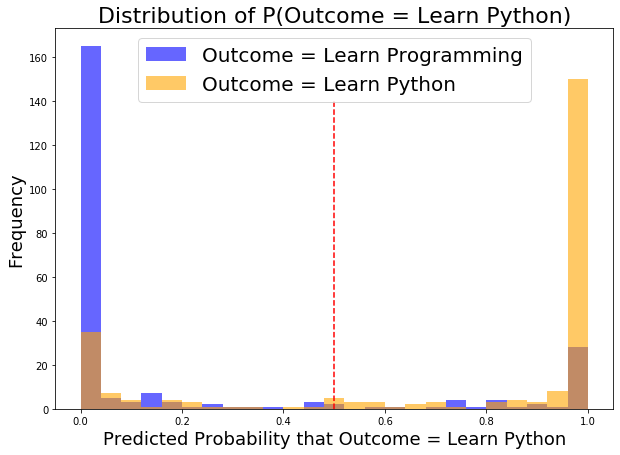

In [76]:
# Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins=25,
         color='blue',
         alpha = 0.6,
         label='Outcome = Learn Programming')
plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins=25,
         color='orange',
         alpha = 0.6,
         label='Outcome = Learn Python')

# Add vertical line at P(Outcome = 1) = 0.5.
plt.vlines(x=0.5,
           ymin = 0,
           ymax = 140,
           color='r',
           linestyle = '--')

# Label axes.
plt.title('Distribution of P(Outcome = Learn Python)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = Learn Python', fontsize=18)

# Create legend.
plt.legend(fontsize=20);

The above shows the distribution of the predicted probabilities. There are 2 peaks at each end, which is a characteristic of a bimodal distribution. This distribution is aligned with what our model is trying to achieve, classifying between 2 distinct classes, learn python and learn programming.

Colored in blue are the outcomes classified as learn programming and orange classified as learn python. In a perfect model where every classification is correct, you will see that all the orange will be to the right of the red line while all the blues will be to the left. 

We can see that there are misclassifications, the blues that are at the right of the red line and orange that are at the left. From the above, we can see that the ratio of misclassifications are low compared to the observations where the correct classifications are made. 

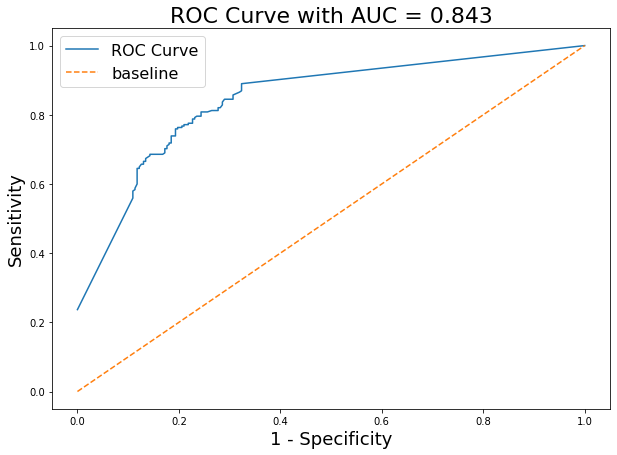

In [63]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values. (Dashed red line in image.)
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f'ROC Curve with AUC = {round(roc_auc_score(pred_df["true_values"], pred_df["pred_probs"]),3)}', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

The above shows a ROC AUC plot. What we wish to see in a good model is that the ROC AUC is above 0.5 and close to 1. If we have an ROC AUC of 0.5, that means that our positive and negative population overlaps perfectly, inferring that the model is bad. If it is at 1, it means that our model classify all observations correctly, something which is not possible in real life scenarios. If the ROC AUC is below 0.5, it means that our model inversely classified the observations, positive is classified as negative and vice versa.

From the above we can see that our ROC AUC is 0.843. we can see that our model is doing quite well, although improvements can be made for better classifications.

# Conclusion

Although the last model has a higher score compared to our selected model, it do not answer our busines problem adequately. Its precision is lower compared our selected model and for our business problem, the cost of false positive is higher when compared to the cost of false negative.

For the next iteration to improve this model, we can look at running the model again after moving the posts to their respective classified subreddits to determine and check if the model performed better as we will have lesser overlapped posts due to the close nature of the selected subreddits. Or we can collecting larger dataset then tune our model again to improve its classification accuracy.

When the model is accurate enough, we can expand the usage to other subreddits and consider having subreddit auto-tagging function or subreddit suggestion when a thread starter is creating a post. This decreases the clutterness of information in our subreddits and allows more distinct subreddit categories for users to choose from, increasing user experience and retention, which will in turn increase traffic volume and popularity of reddit to the community.